# __Classification__

Learning Outcomes:
- Apply SVC to data sets to predict binary outcome measures (groups)
- Explore different metrics to evaluate the model performance in classification settings and visualise variable importance
- Investigate the effect of using different types of kernels on the model performance
- Apply SVMs in a regression setting using SVR

In [1]:
 # IMPORTS
    
from sklearn.svm import SVC, LinearSVC, NuSVC, SVR, NuSVR, LinearSVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, classification_report, r2_score


In [2]:
diabetes_metabol_plasma = pd.read_excel('../Data/diabetes_metabolomics_plasma.xlsx')
diabetes_metabol_saliva = pd.read_excel('../Data/diabetes_metabolomics_saliva.xlsx')

In [3]:
display(diabetes_metabol_plasma)
display(diabetes_metabol_plasma.T2D.value_counts())


,AGE,GENDER,BMI,ETH,T2D,sample_id,"1,11-Undecanedicarboxylic acid","1,2-dipalmitoylglycerol","1,2-propanediol","1,3,7-trimethylurate",...,tyrosine,undecanoate (11:0),urate,urea,uridine,valine,xanthine,xylitol,xylonate,xylose
0,34.505133,0,25.010211,2,0,QMDiab-ID222,4.015998,4.822787,5.098491,4.430118,...,6.844272,4.885885,5.824023,7.577408,5.290736,7.239540,4.254777,4.052859,4.387091,4.676128
1,47.066393,1,28.367759,3,0,QMDiab-ID113,4.165116,4.991613,5.064084,4.585177,...,6.755005,4.777224,5.990350,7.465627,5.220019,7.348071,4.183861,4.341484,4.460427,4.585401
2,55.490760,1,29.705644,1,0,QMDiab-ID29,3.928917,4.965361,5.185007,4.006547,...,6.971284,4.737634,5.892525,7.433326,5.188568,7.356957,4.350213,4.101610,4.726884,4.785554
3,56.334018,1,23.140496,2,0,QMDiab-ID243,4.272476,4.819821,5.015473,4.564346,...,6.943175,4.736576,5.832160,7.422004,5.037060,7.260422,4.037787,4.111296,4.488342,4.696762
4,35.630390,1,30.062295,1,0,QMDiab-ID270,3.914247,4.900546,5.264884,3.719528,...,7.068370,4.754971,6.013982,7.786201,5.388167,7.377851,4.211793,4.099279,4.545646,4.630343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,41.555099,1,31.226902,3,1,QMDiab-ID352,3.789043,5.031615,5.027154,4.505149,...,7.031340,4.738535,5.999672,7.542517,5.240683,7.371381,4.560466,4.184835,4.416036,4.757752
352,52.553046,0,29.075772,2,1,QMDiab-ID135,3.855711,5.373312,5.659572,3.655574,...,6.754284,4.746028,5.766906,7.492505,5.200934,7.252580,4.302257,4.209577,4.641497,5.819027
353,30.313484,0,22.226562,2,0,QMDiab-ID229,4.358841,4.959806,5.193048,4.196916,...,6.898343,4.765964,5.689269,7.383221,5.286181,7.198497,4.295138,4.048126,4.469194,4.646456
354,49.409993,1,33.720082,1,1,QMDiab-ID202,3.826609,4.992705,5.008776,4.296090,...,7.024660,4.647837,5.957494,7.529234,5.175298,7.365286,4.689517,4.469283,4.611671,4.756934


1    179
0    177
Name: T2D, dtype: int64

### Preprocessing 

In [36]:
# Split the data into train and test sets
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(diabetes_metabol_plasma.iloc[:, 6:], diabetes_metabol_plasma.T2D, test_size=0.2, random_state=56)


If you `display(X_test_unscaled, y_test)` you will notice that the function retains the index values for each sample, so you can check that the splitting and the respective `y` targets (T2D status) have been split correctly. 

In [37]:
# Scale the data with standard scaling (0 mean and unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

## Support Vector Classifiers

In [38]:
# Define the classifier with the standard parameters set by sklearn 
clf = SVC(kernel='rbf')

# Fit your first SVC model 
clf.fit(X_train, y_train)

# Predict the test set 
y_pred = clf.predict(X_test)


In [39]:
# Now let's try with a linear kernel...
clf_linear = LinearSVC(C=1.4)

# Fit your first SVC model 
clf_linear.fit(X_train, y_train)

# Predict the test set 
y_pred_linear = clf_linear.predict(X_test)

### Accuracy metrics

We will explore a variety of metrics commonly used to evaluate classification models. The functions we will use are all found under `sklearn.metrics`. Please take some time to read the [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html) and familiarise yourself with the differences between accuracy, AUC (Area Under the ROC Curve), f1 score, precision, recall etc. 

In [17]:
accuracy = accuracy_score(y_test, y_pred)
display(accuracy)

0.8333333333333334

array([[28,  8],
       [ 4, 32]])

[Text(0, 0.5, 'Healthy'), Text(0, 1.5, 'T2D')]

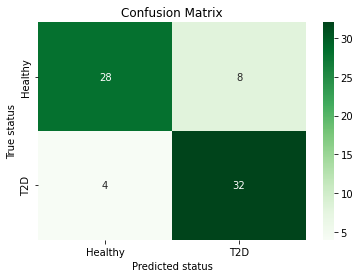

In [18]:
ax = plt.subplot()
cm = confusion_matrix(y_test, y_pred)
display(cm)
sns.heatmap(cm, annot=True, ax=ax, cmap='Greens'); #annot=True to annotate cells
ax.set_xlabel('Predicted status')
ax.set_ylabel('True status')
ax.set_title('Confusion Matrix')

# in this case 0 is Healthy and 1 is T2D samples therefore we can name the labels 
ax.xaxis.set_ticklabels(['Healthy', 'T2D'])
ax.yaxis.set_ticklabels(['Healthy', 'T2D'])

In [19]:
auc = roc_auc_score(y_test, clf.decision_function(X_test), average='macro')
display(auc)

auc = roc_auc_score(y_test, clf.decision_function(X_test), average='micro')
display(auc)

auc = roc_auc_score(y_test, clf.decision_function(X_test), average='weighted')
display(auc)

0.9513888888888888

0.9513888888888888

0.9513888888888888

In [20]:
roc = roc_curve(y_test, clf.decision_function(X_test))
display(roc)
fpr = roc[0]
tpr = roc[1]

(array([0.        , 0.        , 0.        , 0.08333333, 0.08333333,
        0.11111111, 0.11111111, 0.25      , 0.25      , 0.36111111,
        0.36111111, 0.41666667, 0.41666667, 1.        ]),
 array([0.        , 0.02777778, 0.80555556, 0.80555556, 0.83333333,
        0.83333333, 0.88888889, 0.88888889, 0.91666667, 0.91666667,
        0.94444444, 0.94444444, 1.        , 1.        ]),
 array([ 2.84143408,  1.84143408,  0.27115093,  0.20212382,  0.16269552,
         0.14901622,  0.13282756, -0.01693465, -0.0297349 , -0.1133419 ,
        -0.16006657, -0.22981329, -0.3068528 , -1.24459648]))

/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


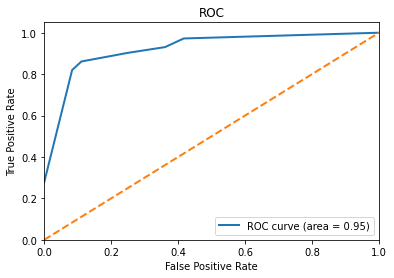

In [21]:
sns.lineplot(fpr,tpr,lw=2,label="ROC curve (area = %0.2f)" % auc, ci=None)
sns.lineplot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")


In [22]:
f1 = f1_score(y_test, y_pred)
display(f1)

0.8421052631578948

In [ ]:
# Try calculating the above metrics for the Linear kernel predictions...



### Parameter optimisation

You will notice that the `SVC()` function used above contains a number of parameters that need to be set by the user in order to optimise the model. The parameter `C` functions as a regularisation parameter and non-linear kernels (like the radial basis function (`rbf`) that we used above) require the `gamma` parameter which defines the kernel coefficient. For a more detailed explanation, you can study the kernel functions further on the [documentation](https://scikit-learn.org/stable/modules/svm.html#svm-kernels).

We will use the [`GridSearchCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to find the optimal parameters that maximise the accuracy of our model. 

In [27]:
# define parameters range or set more than one sklearn-given options
param_grid = {'C': np.logspace(-2, 10, 13), 
              'gamma': ['scale', 'auto'], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
             }

gridcv = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=1, n_jobs=-1)


# fit the model for grid search 
gridcv.fit(X_train, y_train) 
 
# display best parameters after tuning 
display(gridcv.best_params_) 
gridcv_pred = gridcv.predict(X_test) 
   
# classification report 
print(classification_report(y_test, gridcv_pred)) 

Fitting 5 folds for each of 104 candidates, totalling 520 fits


{'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}

              precision    recall  f1-score   support

           0       0.91      0.86      0.89        36
           1       0.87      0.92      0.89        36

    accuracy                           0.89        72
   macro avg       0.89      0.89      0.89        72
weighted avg       0.89      0.89      0.89        72



### Feature Selection

Ofter when we have a lot of features in our dataset we want to eliminate those that do not contribute much to the classification, or select the featues that drive the classification.One of the most used feature selection techniques is __Recursive Feature Elimination (RFE)__. Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached. To find out more about RFE or other feature selection methods, read thourgh the [documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). Here we will use the cross-validation RFE function [`RFECV()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV).   

We will use the [`NuSVC()`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html) function which is similar to the previously used SVC but uses the `nu` parameter to control the number of support vectors. 

In [28]:
# define the classifier of choice and its parameters
clf = NuSVC(
    nu=0.5, 
    kernel='linear', 
    gamma='scale'
)

# create the rfe object
rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=5,
    scoring="accuracy",
    min_features_to_select=1,
)

%time rfecv.fit(X_train, y_train)

display('optimal n of features: %d' % rfecv.n_features_)


CPU times: user 1min 50s, sys: 1.55 s, total: 1min 52s
Wall time: 16.8 s


'optimal n of features: 16'

/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/home/mk218/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass th

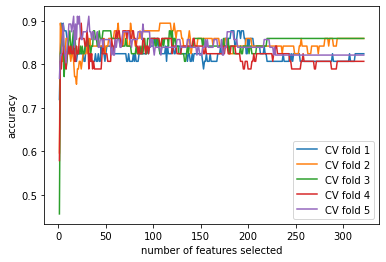

In [31]:
# plot the change in accuracy when looking at the step-wise different number of features
plt.xlabel("number of features selected")
plt.ylabel("accuracy")
for i in range(0,5):
    sns.lineplot(
        range(1, len(rfecv.grid_scores_) + 1),
        rfecv.grid_scores_[:, i],
        label=f'CV fold {i+1}'
    )

### __Your turn...__

Try defining a new classifier with the [`LinearSVC()`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) function and perform a grid search to decide the best `C` values for the model. 

Then apply RFE cross-validation and use the optimal number of features and the selected features to run your model. _Hint_: to get the selected features use the `rfecv.support_` attribute which gives you a mask [True (selected), False (not selected)] array of all the features.  


In [ ]:
# define the classifier 

# set the parameter grid 

# create the rfe object



#### Regression

Load an appropriate dataset with continuous target variables and repeat the above parts of the tutorial for Support Vector Regression models.

The [`SVR()`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) function requires the same parameters that you encountered before (C, kernel, gamma (for non-linear kernels) etc) with an additional parameter `epsilon` being added. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value. Similar to the classification objects we used above, sklearn defines [`NuSVR()`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVR.html#sklearn.svm.NuSVR) and [`LinearSVR()`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR) objects for regression tasks as well. 

In [40]:
# split the data into train and test sets; the BMI values which will be our target (y) for this regression example 
X_train_reg_unscaled, X_test_reg_unscaled, y_train_reg, y_test_reg = train_test_split(diabetes_metabol_plasma.iloc[:,6:], diabetes_metabol_plasma.BMI, test_size=0.2, random_state=56)

# scaling 
scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train_reg_unscaled)
X_test_reg = scaler.transform(X_test_reg_unscaled)


In [41]:
# define the regressor with the default sklearn parameters 
regr = SVR() # here the epsilon value is the default 0.1

regr.fit(X_train_reg, y_train_reg)
y_pred_reg = regr.predict(X_test_reg)

r2 = r2_score(y_test_reg, y_pred_reg) # another metric used in regression is Mean Squared Error (MSE)

# try to plot these results 


_Hint:_ sklearn has a few good examples for plotting results -- a few to look at is this [comparison of kernel ridge regression and SVR](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_ridge_regression.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-ridge-regression-py) and the examples on [model complexity influence](https://scikit-learn.org/stable/auto_examples/applications/plot_model_complexity_influence.html#sphx-glr-auto-examples-applications-plot-model-complexity-influence-py)

In addition make sure to investigate the different metrics used to evaluate regression models, some examples include the r2 score, mean squared error, mean absolute error, and others.  

